In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import folium
import base64
import branca
import time
%matplotlib inline

Step 1. Visualize contents

In [2]:
df = pd.read_csv("./honhyo_2019.csv",encoding='cp932')
print(df.columns)

Index(['資料区分', '都道府県コード', '警察署等コード', '本票番号', '事故内容', '死者数', '負傷者数', '路線コード',
       '上下線', '地点コード', '市区町村コード', '発生日時　　年', '発生日時　　月', '発生日時　　日', '発生日時　　時',
       '発生日時　　分', '昼夜', '天候', '地形', '路面状態', '道路形状', '環状交差点の直径', '信号機',
       '一時停止規制　標識（当事者A）', '一時停止規制　表示（当事者A）', '一時停止規制　標識（当事者B）',
       '一時停止規制　表示（当事者B）', '車道幅員', '道路線形', '衝突地点', 'ゾーン規制', '中央分離帯施設等', '歩車道区分',
       '事故類型', '年齢（当事者A）', '年齢（当事者B）', '当事者種別（当事者A）', '当事者種別（当事者B）',
       '用途別（当事者A）', '用途別（当事者B）', '車両形状（当事者A）', '車両形状（当事者B）',
       '速度規制（指定のみ）（当事者A）', '速度規制（指定のみ）（当事者B）', '車両の衝突部位（当事者A）',
       '車両の衝突部位（当事者B）', '車両の損壊程度（当事者A）', '車両の損壊程度（当事者B）', 'エアバッグの装備（当事者A）',
       'エアバッグの装備（当事者B）', 'サイドエアバッグの装備（当事者A）', 'サイドエアバッグの装備（当事者B）',
       '人身損傷程度（当事者A）', '人身損傷程度（当事者B）', '地点　緯度（北緯）', '地点　経度（東経）', '曜日(発生年月日)',
       '祝日(発生年月日)'],
      dtype='object')


Step 2. High-light person accident location on map
 - Death is shown as red
 - Injury is shown as yellow

In [71]:
def dms2dec(latlong_raw):
    var_degree = int(latlong_raw/1e7)
    var_minutes = int(latlong_raw/1e5 - var_degree*100) 
    var_seconds = (latlong_raw/1e3 - var_degree*1e4 - var_minutes*100)
    decimal_latlong = var_degree + var_minutes/60 + var_seconds/3600
    
    return decimal_latlong

def addLatLong2map(df_in, color_in, folium_map, legend_name, radius_size):
    lgd_txt = '<span style="color: {col};">{txt}</span>'
    if (len(df_in) > 20000):
        FeatureGroup_in = folium.FeatureGroup(name= lgd_txt.format( txt= legend_name, col= color_in), show=False)
    else:
        FeatureGroup_in = folium.FeatureGroup(name= lgd_txt.format( txt= legend_name, col= color_in))
        
    for index_df in range(len(df_in)):
        _latitude = dms2dec(df_in["地点　緯度（北緯）"][index_df])
        _longitude = dms2dec(df_in["地点　経度（東経）"][index_df])
        if (df_in['当事者種別（当事者A）'][index_df] == 61):
            _pedestrian_age = df_in['年齢（当事者A）'][index_df]
        elif (df_in['当事者種別（当事者B）'][index_df] == 61):
            _pedestrian_age = df_in['年齢（当事者B）'][index_df]
        else:
            _pedestrian_age = 999
        gmap_html = 'https://www.google.com/maps/@{0},{1},0a,75y,90t/data=!3m3!1e1!3m1!2e0'.format(_latitude,_longitude)
        gmap_str = "<a href='{}'>Link to StreetView</a>".format(gmap_html)
        
        popup_str = 'location: {0},{1}<br>'.format(_latitude, _longitude) + 'age: {}<br>'.format(_pedestrian_age)
        popup_str += gmap_str
        
        popup=folium.Popup(popup_str, max_width=1000,show=False)
        
        folium.CircleMarker([_latitude, _longitude],
                             radius=radius_size,color=color_in, popup=popup,
                             fill=True,fill_opacity=0.9).add_to(FeatureGroup_in)
    folium_map.add_child(FeatureGroup_in)
        

In [ ]:
# create map
folium_map = folium.Map(location=[35.415377, 139.595271], zoom_start=13)

# for loop for lat/long
df_person = df[df["事故類型"]==1].reset_index()
df_nodeath = df_person[df_person['死者数'] == 0].reset_index()
del df_nodeath['index']
df_young_A = df_nodeath[df_nodeath['当事者種別（当事者A）'] == 61][df_nodeath['年齢（当事者A）'] < 41]
df_young_B = df_nodeath[df_nodeath['当事者種別（当事者B）'] == 61][df_nodeath['年齢（当事者B）'] < 41]
df_young = pd.concat([df_young_A,df_young_B],axis=0).reset_index()
df_old_A = df_nodeath[df_nodeath['当事者種別（当事者A）'] == 61][df_nodeath['年齢（当事者A）'] > 40]
df_old_B = df_nodeath[df_nodeath['当事者種別（当事者B）'] == 61][df_nodeath['年齢（当事者B）'] > 40]
df_old = pd.concat([df_old_A,df_old_B],axis=0).reset_index()
df_death = df_person[df_person['死者数'] > 0].reset_index()

start_time = time.time()

addLatLong2map(df_old,'#ffa500',folium_map, 'pedestrian accident (age > 40)',2)
addLatLong2map(df_young,'#ff0000',folium_map, 'pedestrian accident (age <= 40)',3)
print("--- %s seconds for accident loop ---" % (time.time() - start_time))

addLatLong2map(df_death,'#000000',folium_map, 'pedestrian death',3)

# turn on layer control
folium_map.add_child(folium.map.LayerControl())

print("--- %s seconds until all loop ---" % (time.time() - start_time))
    
# save map
folium_map.save('./docs/JapanTrafficAccident.html')
print("--- %s seconds until save map ---" % (time.time() - start_time))

folium_map

C:\Users\uidp4921\AppData\Local\Continuum\miniconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\uidp4921\AppData\Local\Continuum\miniconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
C:\Users\uidp4921\AppData\Local\Continuum\miniconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\uidp4921\AppData\Local\Continuum\miniconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


--- 10.724291324615479 seconds for accident loop ---
--- 10.932741165161133 seconds until all loop ---


# Appendix

,年齢（当事者A）,年齢（当事者B）,当事者種別（当事者A）,当事者種別（当事者B）,死者数
0,65,35,3,61,0
1,65,1,3,61,0
2,55,55,3,61,0
3,65,25,3,61,0
4,55,75,3,61,0


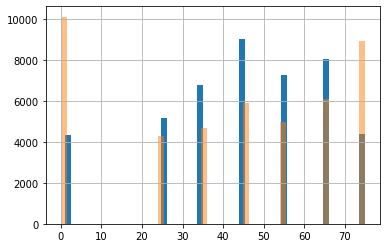

In [16]:
df_person = df[df["事故類型"]==1].reset_index()
df_person['年齢（当事者A）'].hist(bins=50)
df_person['年齢（当事者B）'].hist(bins=50, alpha=0.5)
#test_location = [dms2dec(df_person["地点　緯度（北緯）"][0]), dms2dec(df_person["地点　経度（東経）"][0])]
#print(test_location)
df_person[['年齢（当事者A）', '年齢（当事者B）', '当事者種別（当事者A）', '当事者種別（当事者B）','死者数']].head()
#df_person[df_person['当事者種別（当事者A）'] == 61]

In [ ]:
# visu 1: person vehicle accident rate
Person_vehicle_accident_rate = len(df[df["事故類型"]==1])/len(df)*100
print("Person_vehicle_accident_rate = {:.2f}%".format(Person_vehicle_accident_rate))

# visu 2: monthly accident bar plot
monthly_accident_count = df[df["事故類型"]!=1].groupby(['発生日時　　年', '発生日時　　月']).size()
monthly_person_accident_count = df[df["事故類型"]==1].groupby(['発生日時　　年', '発生日時　　月']).size()
df_monthly_count = pd.concat([monthly_accident_count, monthly_person_accident_count], axis=1)
df_monthly_count.columns = ["Others","Person-Vehicle only"]

ax = df_monthly_count.plot(kind="bar", figsize=(12,3), stacked=True, rot=45)
ax.set_xlabel("date")
ax.set_ylabel("accident count")
ax.set_title("monthly accident")
ax.set_xlim(len(df_monthly_count) - 20,len(df_monthly_count))